<a href="https://colab.research.google.com/github/ianwolf99/Bitcoin_Tracking/blob/main/deeplearningCryptoPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os



In [ ]:
from datetime import datetime, timedelta

# List of cryptocurrency tickers
crypto_tickers = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'XRP-USD', 'BCH-USD']

# Define the end date as today
end_date = datetime.now()

# Define the start date as 5 years ago
start_date = end_date - timedelta(days=5*365)

# Loop through each cryptocurrency ticker and download historical data
for ticker in crypto_tickers:
    # Download historical data
    data = yf.download(ticker, start=start_date, end=end_date)

    # Save each cryptocurrency's historical data to its own CSV file
    file_name = f"{ticker}.csv"
    data.to_csv(file_name)

    print(f"Saved historical data for {ticker} to {file_name}")

this functions are crucial

In [2]:
from datetime import datetime, timedelta

# List of cryptocurrency tickers
crypto_tickers = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'XRP-USD', 'BCH-USD']

# Define the end date as today
end_date = datetime.now()

# Define the start date as 5 years ago
start_date = end_date - timedelta(days=5*365)

# Loop through each cryptocurrency ticker and download historical data
for ticker in crypto_tickers:
    # Download historical data
    data = yf.download(ticker, start=start_date, end=end_date)

    # Save each cryptocurrency's historical data to its own CSV file
    file_name = f"{ticker}.csv"
    data.to_csv(file_name)

    print(f"Saved historical data for {ticker} to {file_name}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved historical data for BTC-USD to BTC-USD.csv
Saved historical data for ETH-USD to ETH-USD.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved historical data for LTC-USD to LTC-USD.csv
Saved historical data for XRP-USD to XRP-USD.csv


[*********************100%***********************]  1 of 1 completed

Saved historical data for BCH-USD to BCH-USD.csv


In [3]:
# Function to prepare the dataset
def prepare_data(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


In [4]:
# Function to add technical indicators
def add_technical_indicators(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['RSI'] = compute_rsi(df['Close'])
    df = df.dropna()
    return df

In [5]:
# Function to compute the Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [6]:
# Function to visualize the data
def plot_data(data, title, xlabel='Days', ylabel='Price'):
    plt.figure(figsize=(14, 7))
    plt.plot(data, label=title)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()


In [17]:
# List of cryptocurrency tickers
crypto_tickers = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'XRP-USD', 'BCH-USD']

# Process each cryptocurrency
from sklearn.metrics import r2_score
for ticker in crypto_tickers:
    # Load the historical data from CSV
    data = pd.read_csv(f"{ticker}.csv")
    
    # Ensure the 'Close' column is present
    if 'Close' not in data.columns:
        print(f"Close column not found in {ticker}.csv")
        continue
    
    # Use only the closing prices
    df = data[['Close']].copy()
    df = add_technical_indicators(df)  # Add technical indicators
    df.dropna(inplace=True)  # Drop rows with NaN values

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Close']])  # Scale only 'Close'

    # Prepare the dataset
    time_step = 60  # Number of days to look back
    X, y = prepare_data(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

    # Split the data into training, validation, and testing sets
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Implement early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model and record the history
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Save the model
    model.save(f'{ticker}_lstm_model.h5')

    # Plot training and validation loss
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for {ticker}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Make predictions for the next 4 days
    last_days = scaled_data[-time_step:].reshape(1, time_step, 1)
    predictions = []

    for _ in range(4):  # Predict for the next 4 days
        pred = model.predict(last_days)
        predictions.append(pred[0][0])
        last_days = np.concatenate([last_days[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)   # Update the last_days with new prediction

    # Inverse transform the predictions to get the actual prices
    predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Print the predictions for the next 4 days
    print(f"\nPredicted prices for the next 4 days for {ticker}:")
    for i, price in enumerate(predicted_prices):
        print(f"Day {i + 1}: {price[0]:.2f}")

    # Visualize the actual vs predicted prices
    # Prepare data for plotting actual prices
    train_predict = model.predict(X_train)
    val_predict = model.predict(X_val)
    test_predict = model.predict(X_test)

    # Inverse transform the predictions to get actual prices
    train_predict = scaler.inverse_transform(train_predict)
    val_predict = scaler.inverse_transform(val_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Combine train and val data for plotting
    train_size = len(train_predict)
    val_size = len(val_predict)
    test_size = len(test_predict)
    
    actual_prices = scaler.inverse_transform(scaled_data)
    
    # Prepare for plotting
    plot_data(actual_prices[0:train_size], f'{ticker} Actual Prices (Training Set)')
    plot_data(train_predict, f'{ticker} Predictions (Training Set)')
    
    # Combine training and validation predictions for final visualization
    combined_predict = np.concatenate((train_predict, val_predict, test_predict), axis=0)

    plt.figure(figsize=(14, 7))
    plt.plot(actual_prices, label='Actual Prices')
    plt.plot(range(time_step, train_size + time_step), train_predict, label='Training Predictions')
    plt.plot(range(train_size + time_step, train_size + time_step + val_size), val_predict, label='Validation Predictions')
    plt.plot(range(train_size + val_size + time_step, train_size + val_size + time_step + test_size),
         test_predict.reshape(-1),  # Reshape to 1D array for plotting
         label='Test Predictions')
    plt.title(f'Actual vs Predicted Prices for {ticker}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Reshape y_test and test_predict to 2D before applying inverse transform
    y_test_reshaped = y_test.reshape(-1, 1)
  test_predict_reshaped = test_predict.reshape(-1, 1)

# Inverse transform both y_test and test_predict
y_test_actual = scaler.inverse_transform(y_test_reshaped)
test_predict_actual = scaler.inverse_transform(test_predict_reshaped)

# Calculate and print the R² score for the test set (accuracy)
r2 = r2_score(y_test_actual, test_predict_actual)
print(f'R² score (accuracy) for {ticker}: {r2:.4f}\n')


print("\nPrediction completed for all cryptocurrencies.")


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0840 - val_loss: 0.0037
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050 - val_loss: 0.0011
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - val_loss: 9.7720e-04
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - val_loss: 8.6167e-04
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - val_loss: 9.1066e-04
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0028 - val_loss: 7.5960e-04
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 9.1944e-04
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - val_loss: 7.4009e-04
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027 - val_loss: 8.2092e-04
Epoch 12/200
38/38 ━━━━━━━━━━━━━━━━━

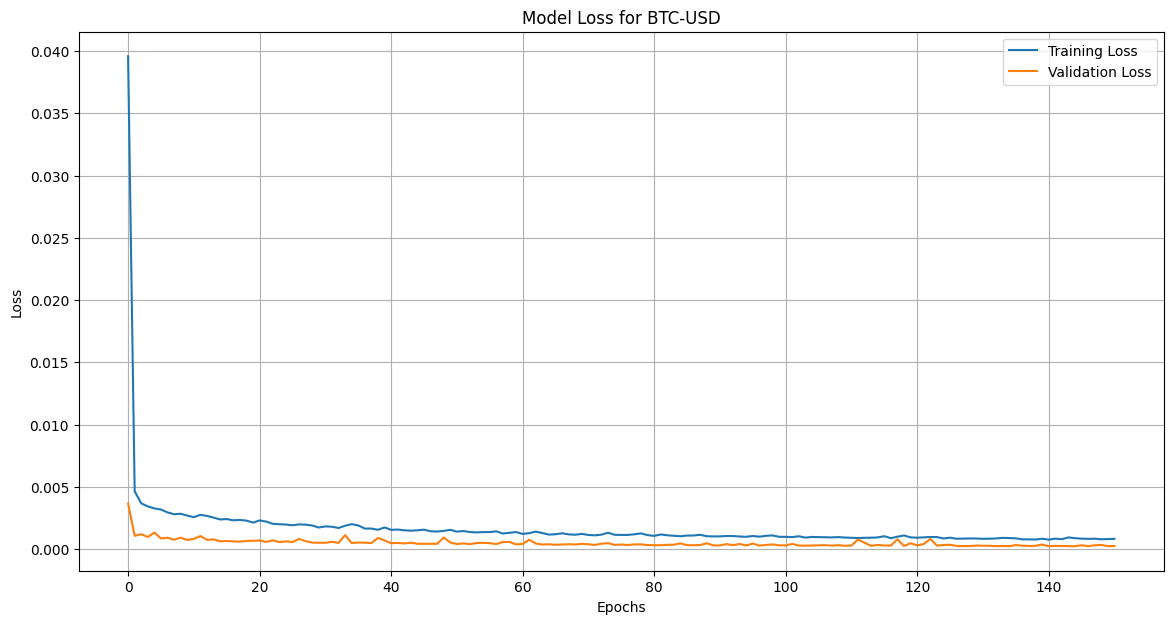

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Predicted prices for the next 4 days for BTC-USD:
Day 1: 64881.41
Day 2: 65154.26
Day 3: 64612.96
Day 4: 63642.61
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


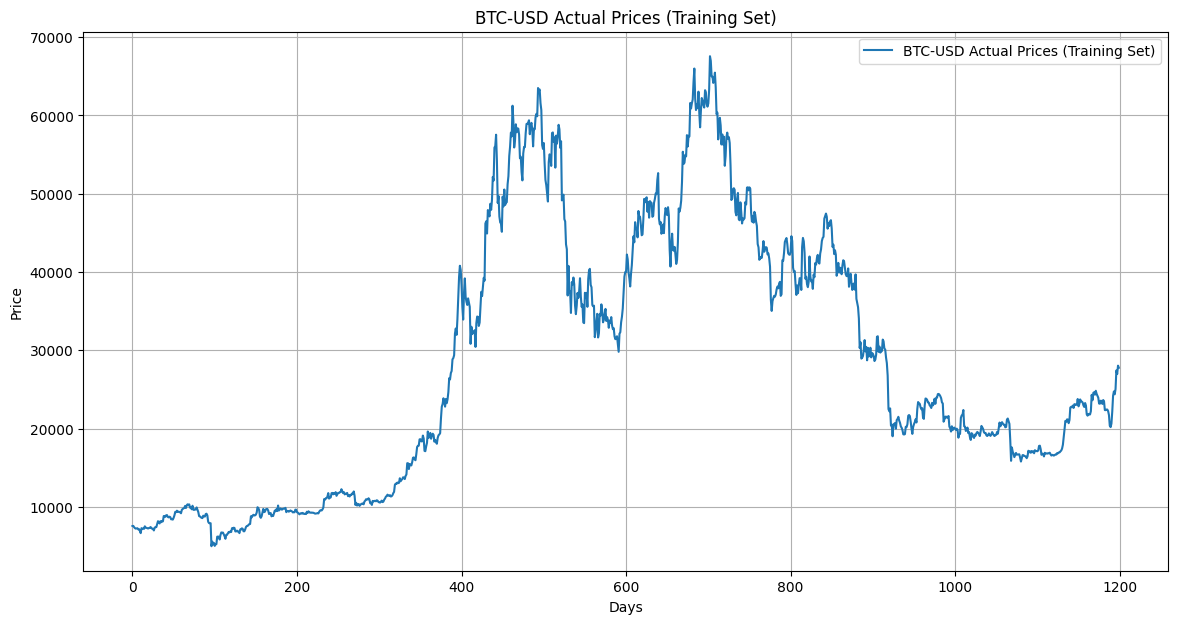

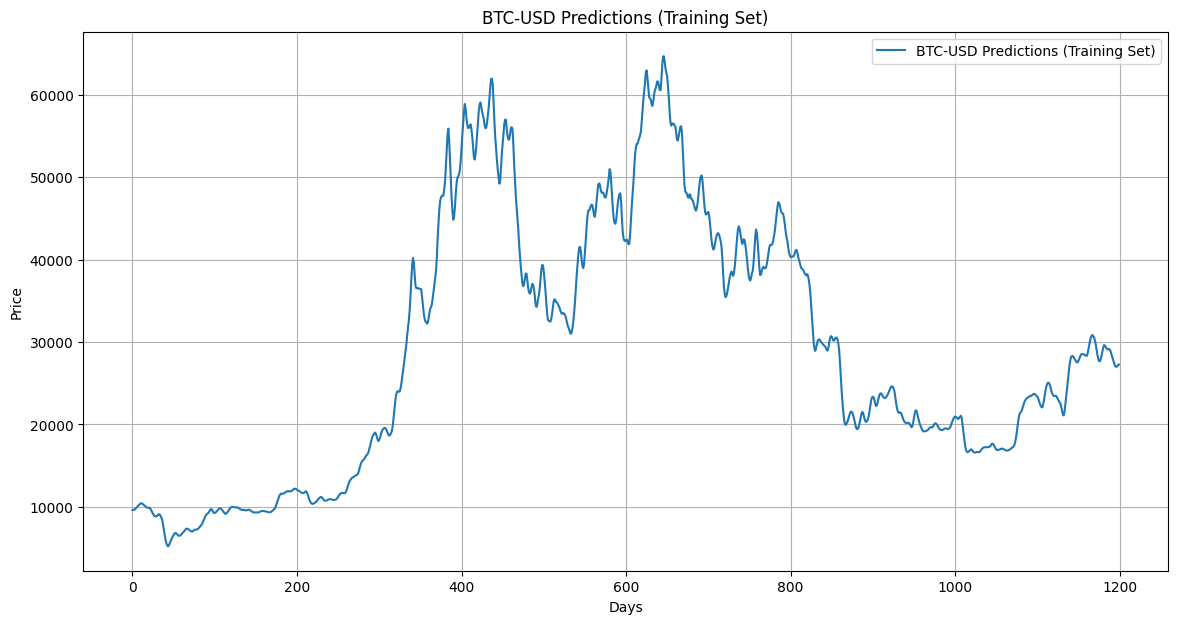

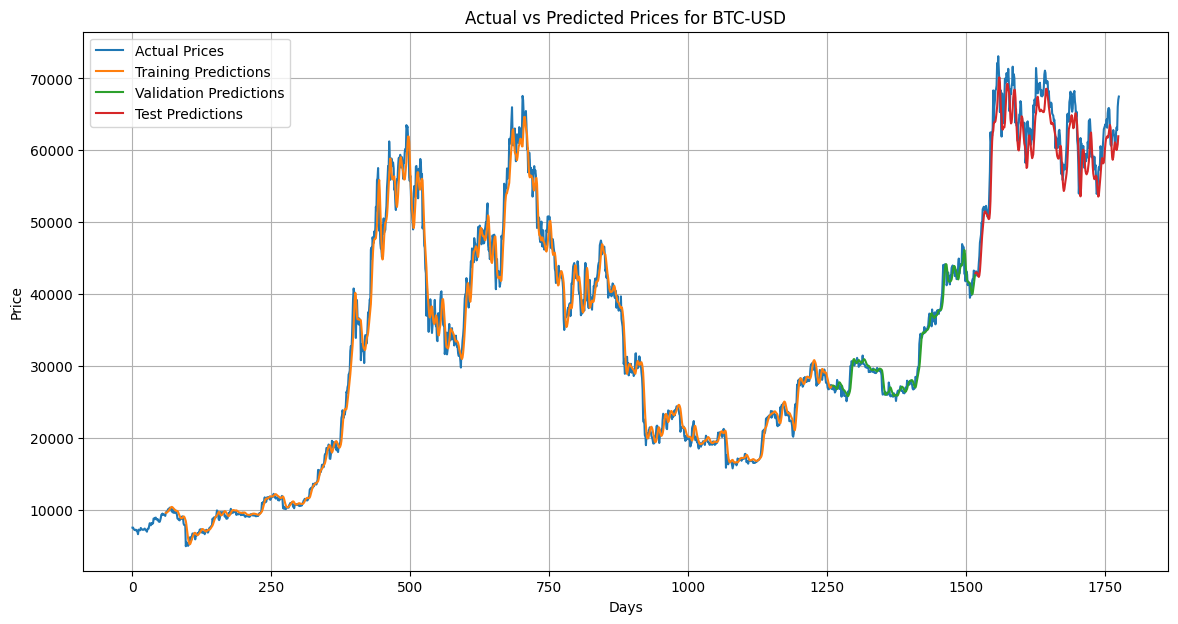

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0742 - val_loss: 0.0022
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0063 - val_loss: 6.1345e-04
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - val_loss: 5.7073e-04
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - val_loss: 5.9408e-04
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0036 - val_loss: 5.3960e-04
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0036 - val_loss: 5.1664e-04
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0039 - val_loss: 5.5164e-04
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - val_loss: 5.2077e-04
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0032 - val_loss: 4.6550e-04
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - val_loss: 4.7226e-04
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - val_loss: 4.9246e-04
Epoch 12/200

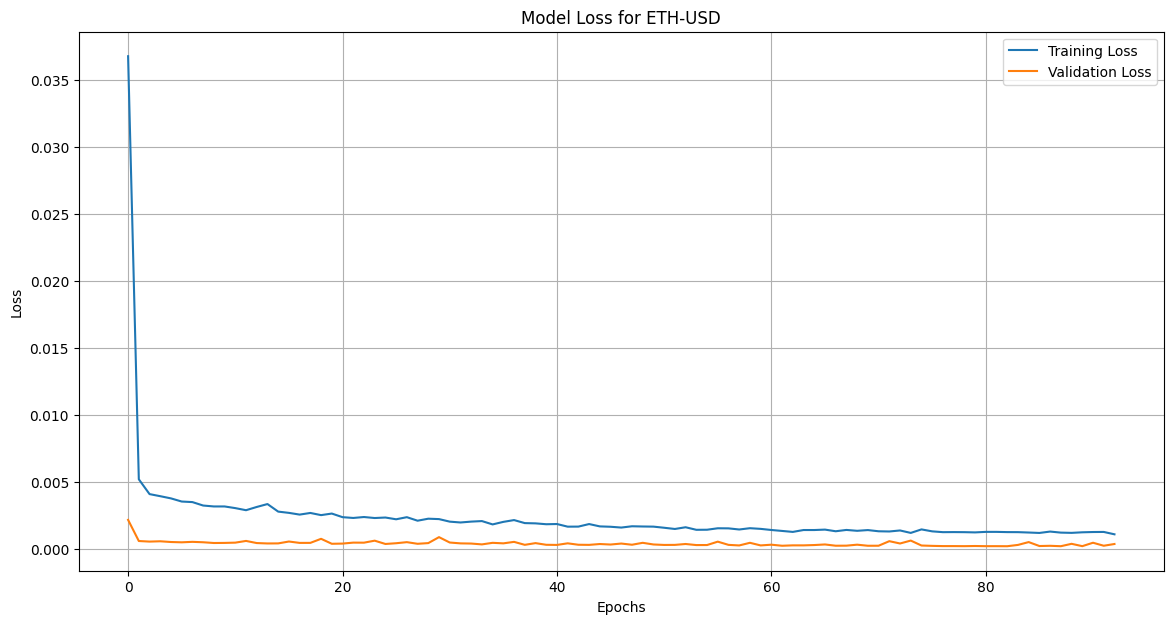

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Predicted prices for the next 4 days for ETH-USD:
Day 1: 2567.12
Day 2: 2597.26
Day 3: 2613.85
Day 4: 2619.65
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


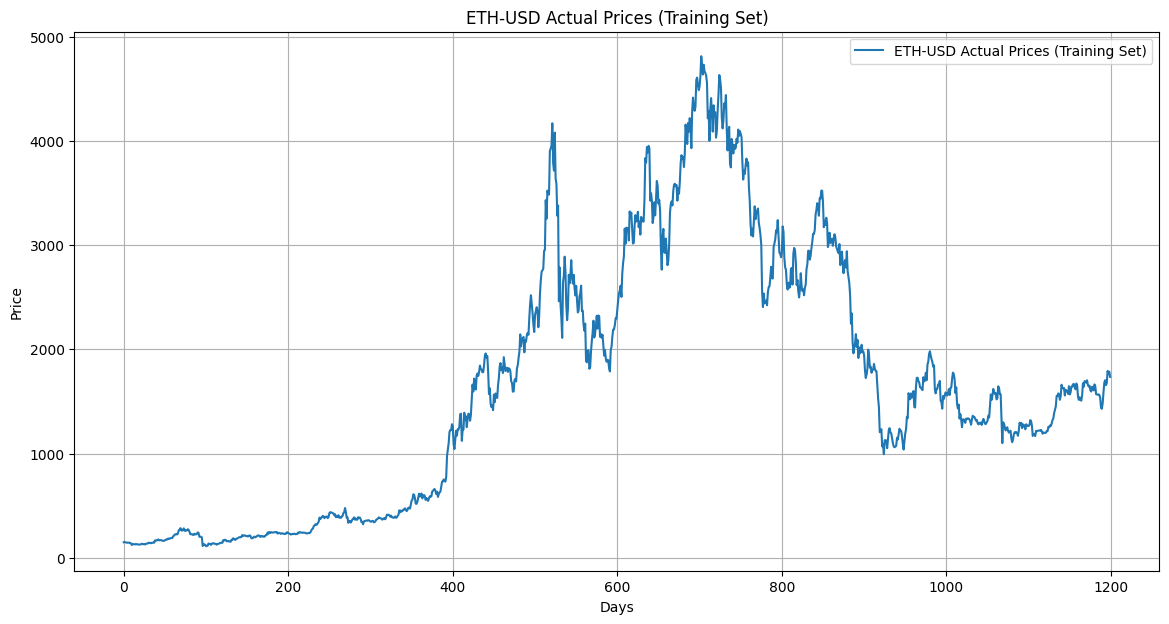

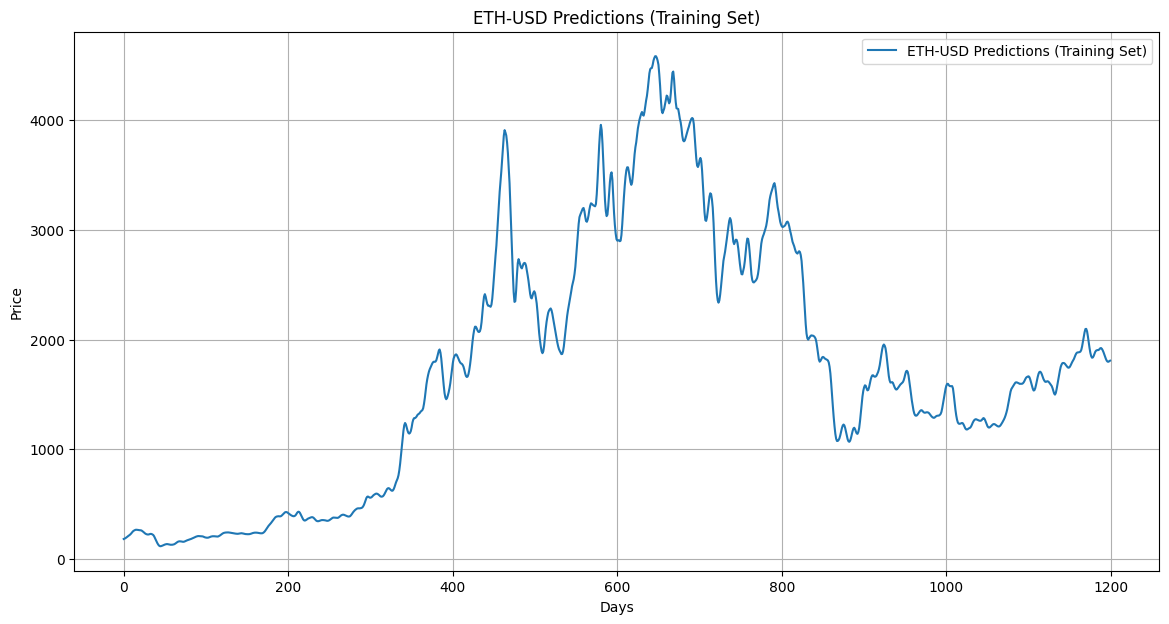

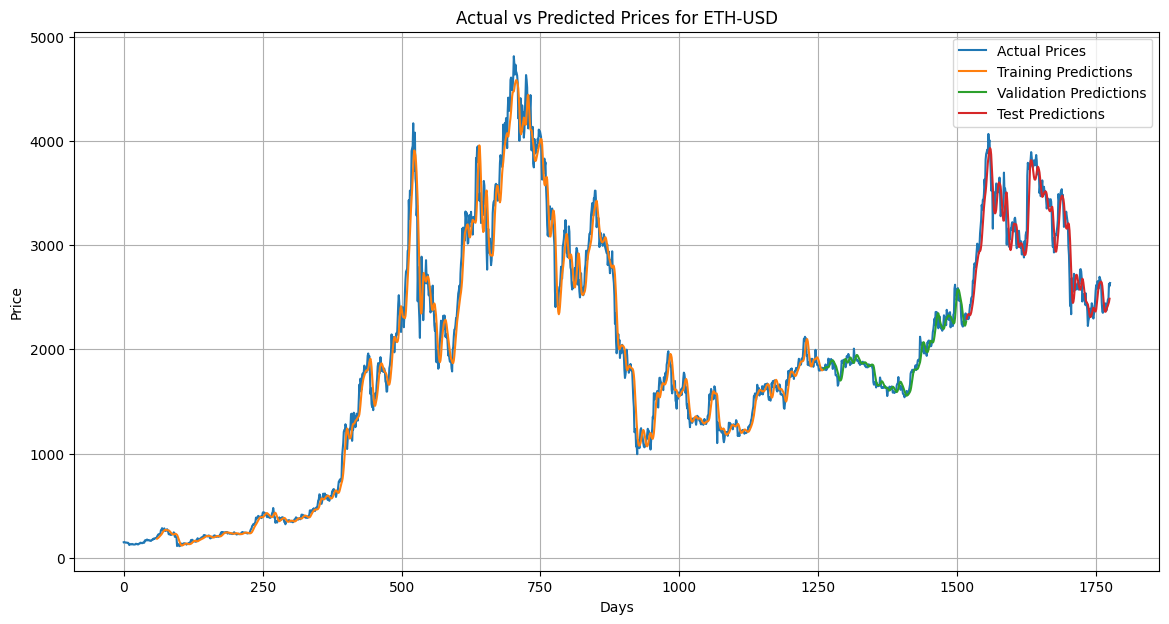

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0401 - val_loss: 4.7087e-04
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0050 - val_loss: 5.5322e-04
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - val_loss: 3.4902e-04
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0037 - val_loss: 4.9763e-04
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035 - val_loss: 4.0621e-04
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033 - val_loss: 4.7119e-04
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0037 - val_loss: 7.6552e-04
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038 - val_loss: 2.9748e-04
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0032 - val_loss: 3.0089e-04
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - val_loss: 4.8868e-04
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - val_loss: 8.9183e-04
Epoch 12/200
38/38 ━

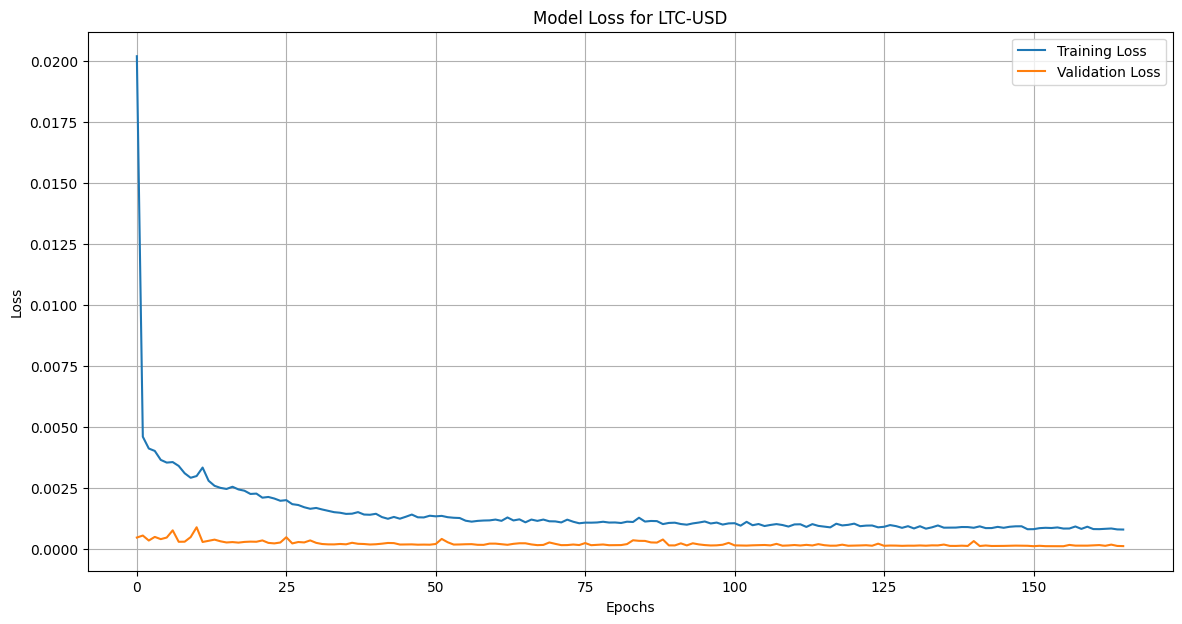

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Predicted prices for the next 4 days for LTC-USD:
Day 1: 67.91
Day 2: 68.64
Day 3: 68.85
Day 4: 68.80
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


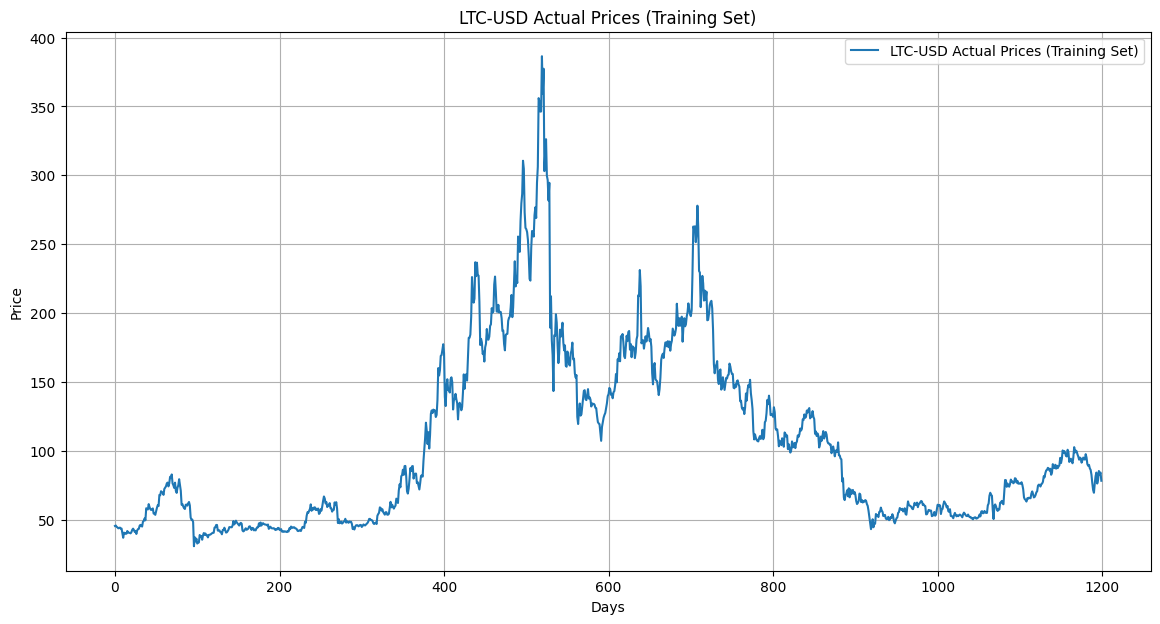

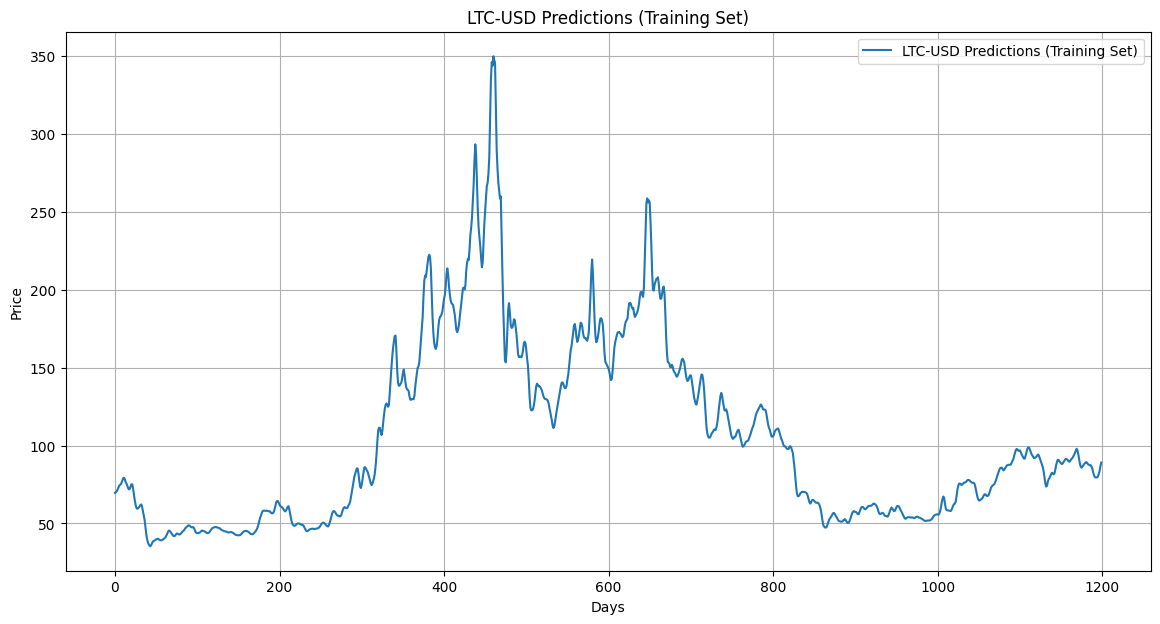

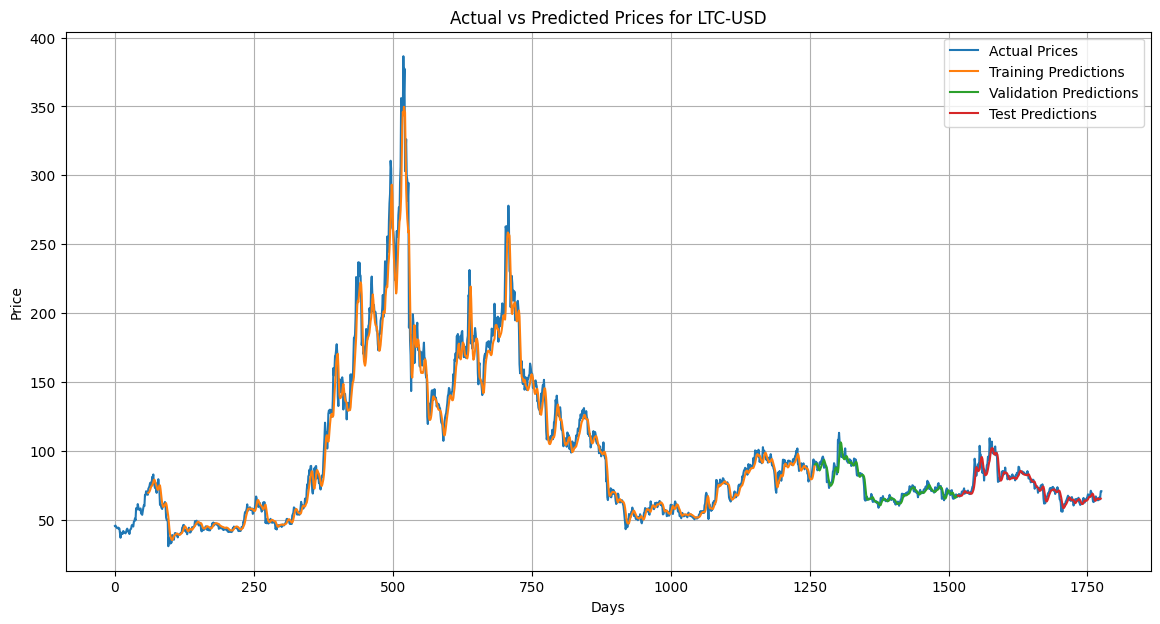

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0452 - val_loss: 0.0019
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0076 - val_loss: 0.0017
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 12/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

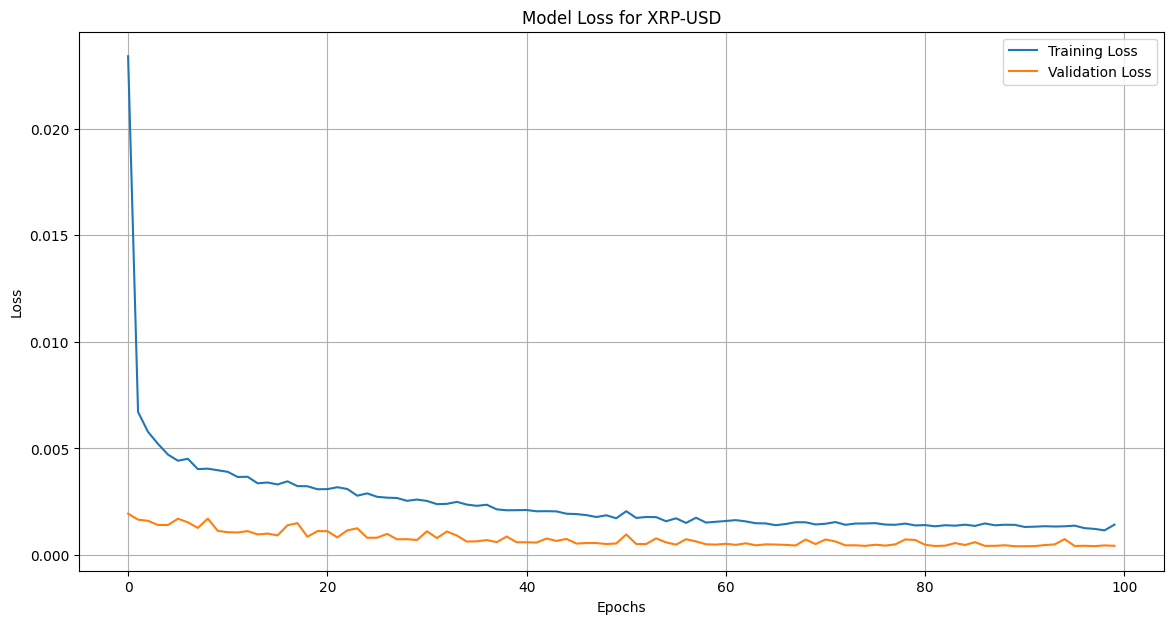

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Predicted prices for the next 4 days for XRP-USD:
Day 1: 0.54
Day 2: 0.54
Day 3: 0.54
Day 4: 0.54
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


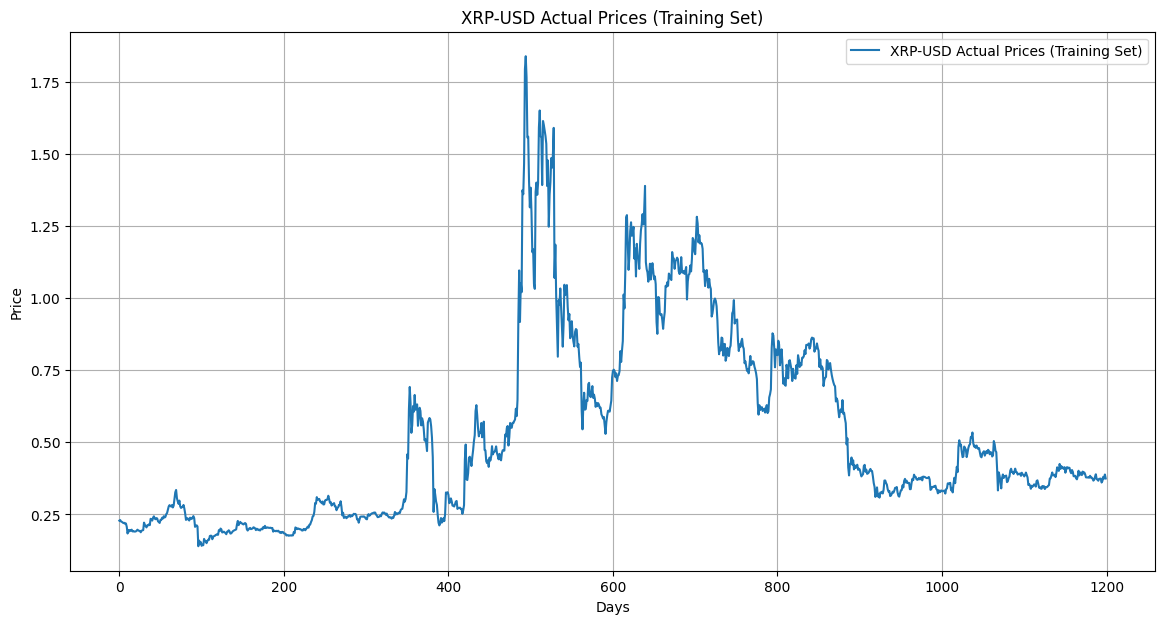

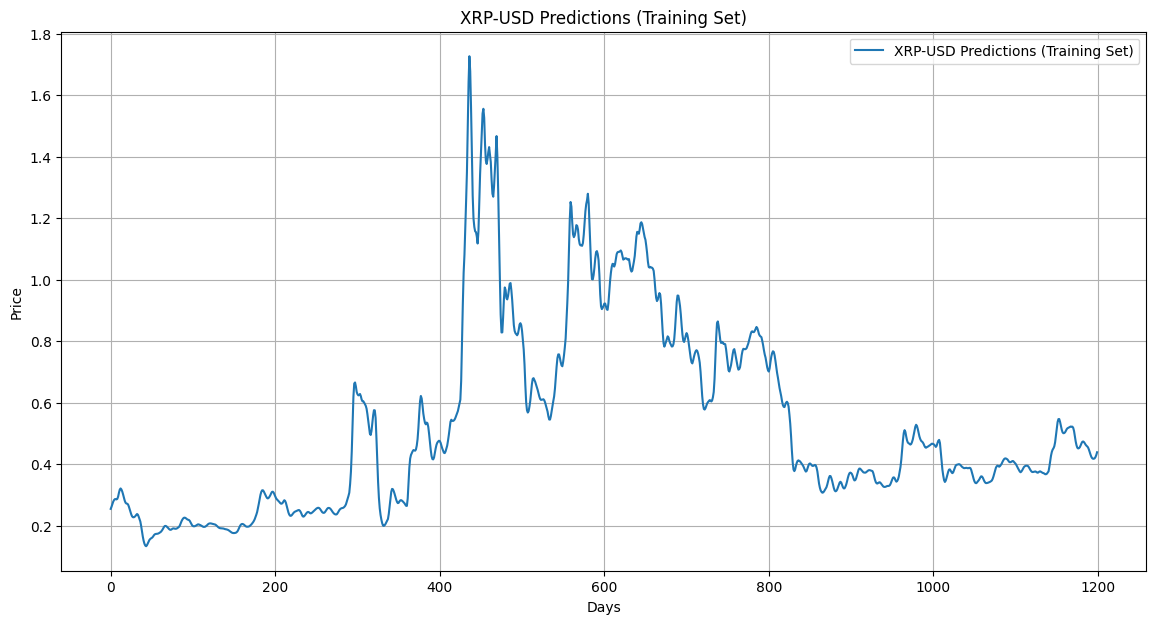

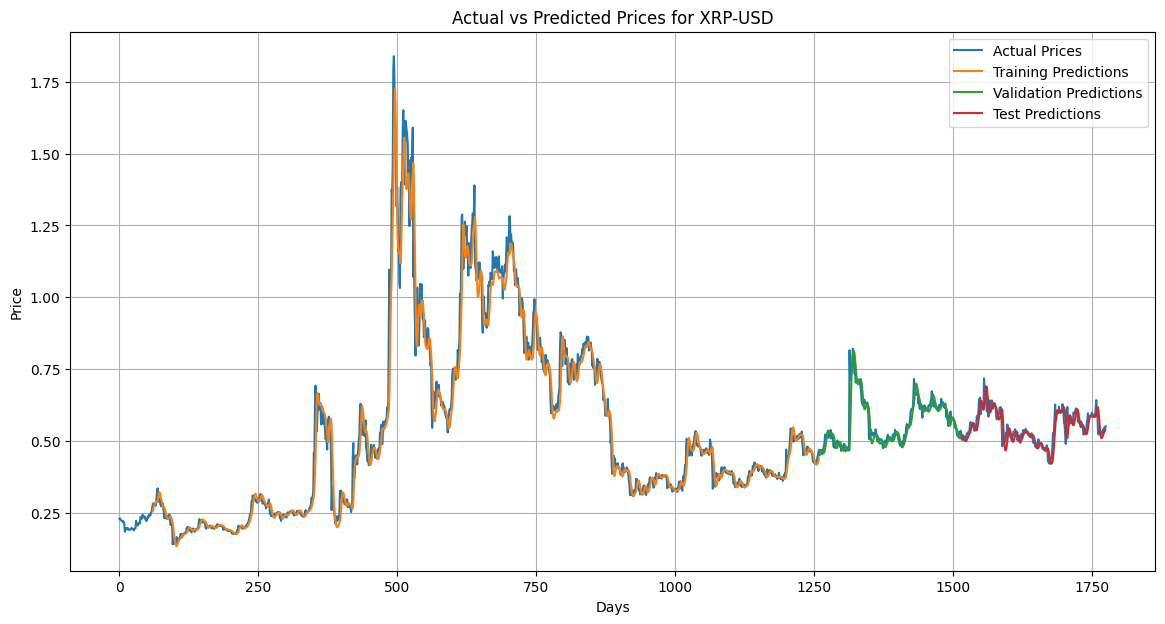

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0238 - val_loss: 4.7741e-04
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - val_loss: 4.8475e-04
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0044 - val_loss: 4.4582e-04
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033 - val_loss: 4.4868e-04
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0037 - val_loss: 4.1192e-04
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0029 - val_loss: 4.0175e-04
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - val_loss: 3.9812e-04
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0031 - val_loss: 4.1714e-04
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 4.4636e-04
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - val_loss: 3.7166e-04
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 4.1120e-04
Epoch 12

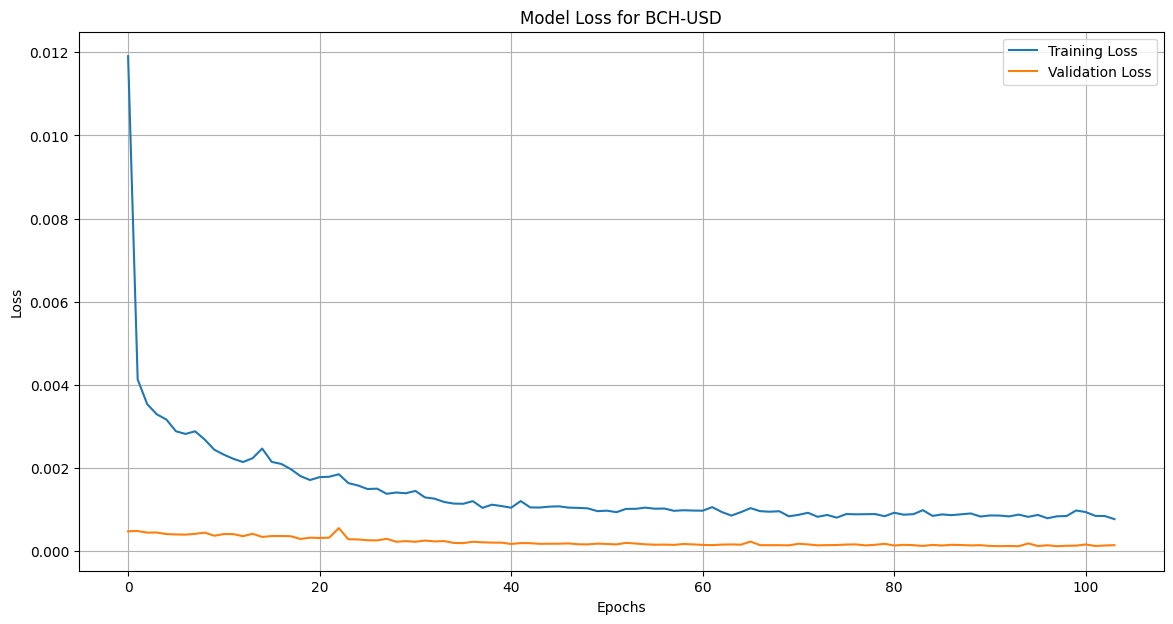

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Predicted prices for the next 4 days for BCH-USD:
Day 1: 346.21
Day 2: 351.81
Day 3: 354.63
Day 4: 355.40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


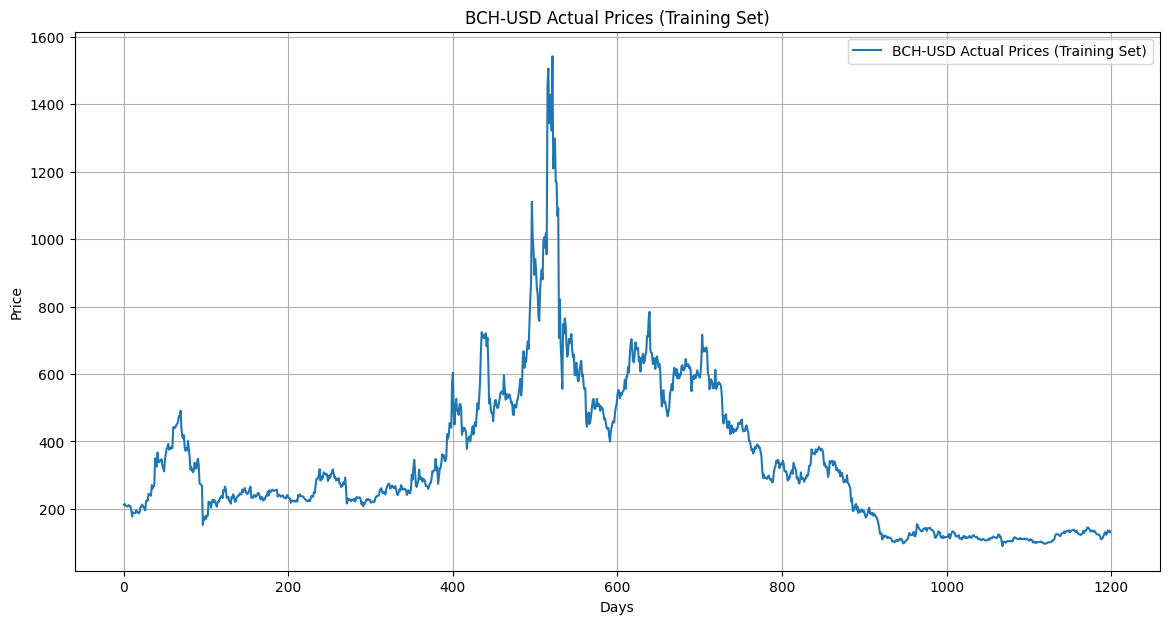

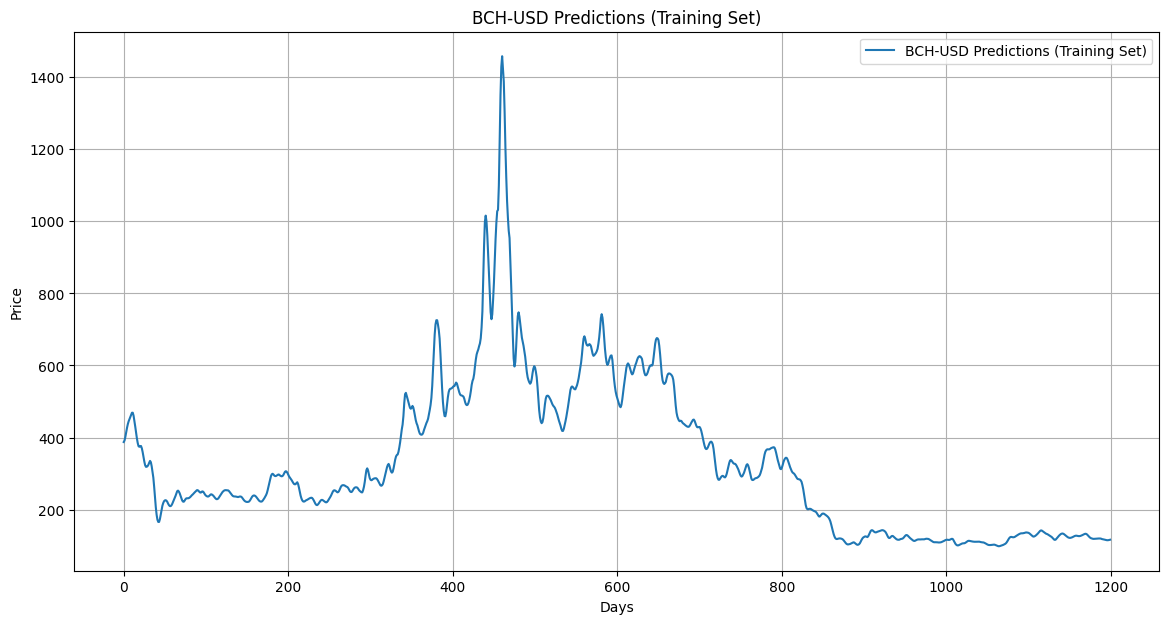

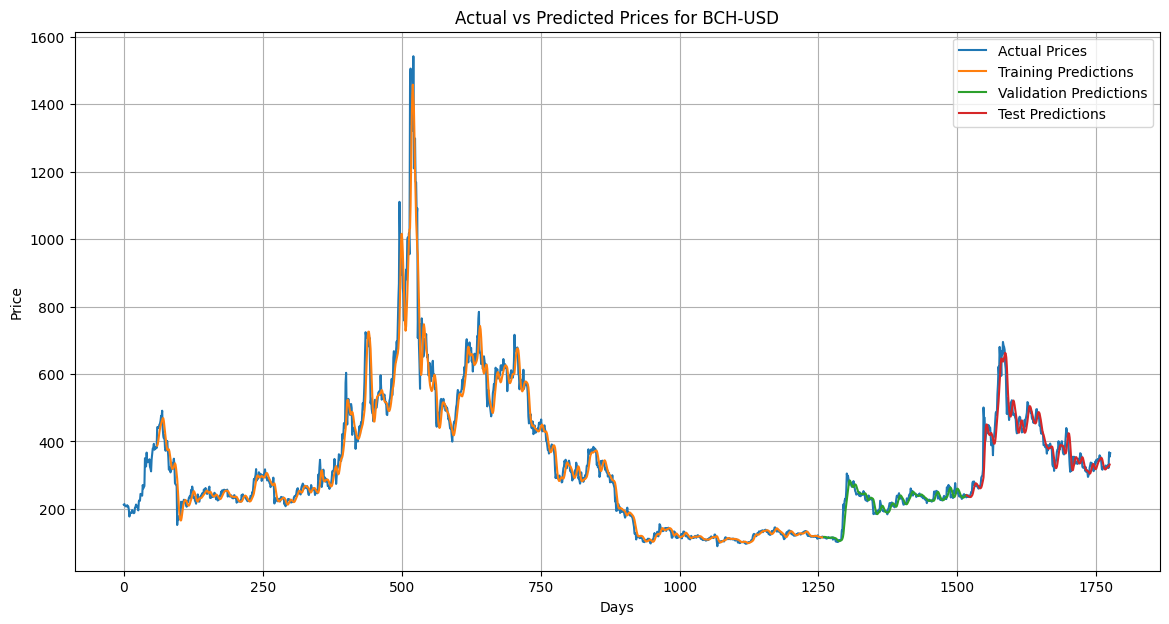


Prediction completed for all cryptocurrencies.


In [20]:
from tensorflow.keras.optimizers import Adam
for ticker in crypto_tickers:
    # Load the historical data from CSV
    data = pd.read_csv(f"{ticker}.csv")

    # Ensure the 'Close' column is present
    if 'Close' not in data.columns:
        print(f"Close column not found in {ticker}.csv")
        continue

    # Use only the closing prices
    df = data[['Close']].copy()
    df = add_technical_indicators(df)  # Add technical indicators
    df.dropna(inplace=True)  # Drop rows with NaN values

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Close']])  # Scale only 'Close'

    # Prepare the dataset
    time_step = 60  # Number of days to look back
    X, y = prepare_data(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

    # Split the data into training, validation, and testing sets
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

    model = Sequential()
    model.add(LSTM(200, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Increase LSTM units
    model.add(Dropout(0.3))  # Increase dropout for regularization
    model.add(LSTM(150, return_sequences=True))  # Add another LSTM layer with fewer units
    model.add(Dropout(0.3))
    model.add(LSTM(100, return_sequences=False))  # Final LSTM layer
    model.add(Dense(1))

    # Experiment with a smaller learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

    # Also, try adding more epochs to let the model converge properly
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
    # Train the model and record the history


    # Save the model
    model.save(f'{ticker}_lstm_model.h5')

    # Plot training and validation loss
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for {ticker}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Make predictions for the next 4 days
    last_days = scaled_data[-time_step:].reshape(1, time_step, 1)
    predictions = []

    for _ in range(4):  # Predict for the next 4 days
        pred = model.predict(last_days)
        predictions.append(pred[0][0])
        last_days = np.concatenate([last_days[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)   # Update the last_days with new prediction

    # Inverse transform the predictions to get the actual prices
    predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Print the predictions for the next 4 days
    print(f"\nPredicted prices for the next 4 days for {ticker}:")
    for i, price in enumerate(predicted_prices):
        print(f"Day {i + 1}: {price[0]:.2f}")

    # Visualize the actual vs predicted prices
    # Prepare data for plotting actual prices
    train_predict = model.predict(X_train)
    val_predict = model.predict(X_val)
    test_predict = model.predict(X_test)

    # Inverse transform the predictions to get actual prices
    train_predict = scaler.inverse_transform(train_predict)
    val_predict = scaler.inverse_transform(val_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Combine train and val data for plotting
    train_size = len(train_predict)
    val_size = len(val_predict)
    test_size = len(test_predict)

    actual_prices = scaler.inverse_transform(scaled_data)

    # Prepare for plotting
    plot_data(actual_prices[0:train_size], f'{ticker} Actual Prices (Training Set)')
    plot_data(train_predict, f'{ticker} Predictions (Training Set)')

    # Combine training and validation predictions for final visualization
    combined_predict = np.concatenate((train_predict, val_predict, test_predict), axis=0)

    plt.figure(figsize=(14, 7))
    plt.plot(actual_prices, label='Actual Prices')
    plt.plot(range(time_step, train_size + time_step), train_predict, label='Training Predictions')
    plt.plot(range(train_size + time_step, train_size + time_step + val_size), val_predict, label='Validation Predictions')
    plt.plot(range(train_size + val_size + time_step, train_size + val_size + time_step + test_size),
         test_predict.reshape(-1),  # Reshape to 1D array for plotting
         label='Test Predictions')
    plt.title(f'Actual vs Predicted Prices for {ticker}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

print("\nPrediction completed for all cryptocurrencies.")
